In [1]:
pip install pmdarima

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import seaborn as sns
import datetime as dt
from datetime import datetime,timedelta 
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.style.use("ggplot")
import numpy as np 
import pandas as pd 
import os
from sklearn.preprocessing import MinMaxScaler
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
df=pd.read_csv("Olist.csv",index_col=0,parse_dates=True)
df

,Revenue
Date,
2016-09-15,134.97
2016-10-03,441.98
2016-10-04,8595.89
2016-10-05,6169.77
2016-10-06,5889.96
...,...
2018-08-25,10599.41
2018-08-26,8070.71
2018-08-27,5345.91


### Đồ thị dữ liệu ban đầu

Text(0.5, 1.0, 'Doanh thu')

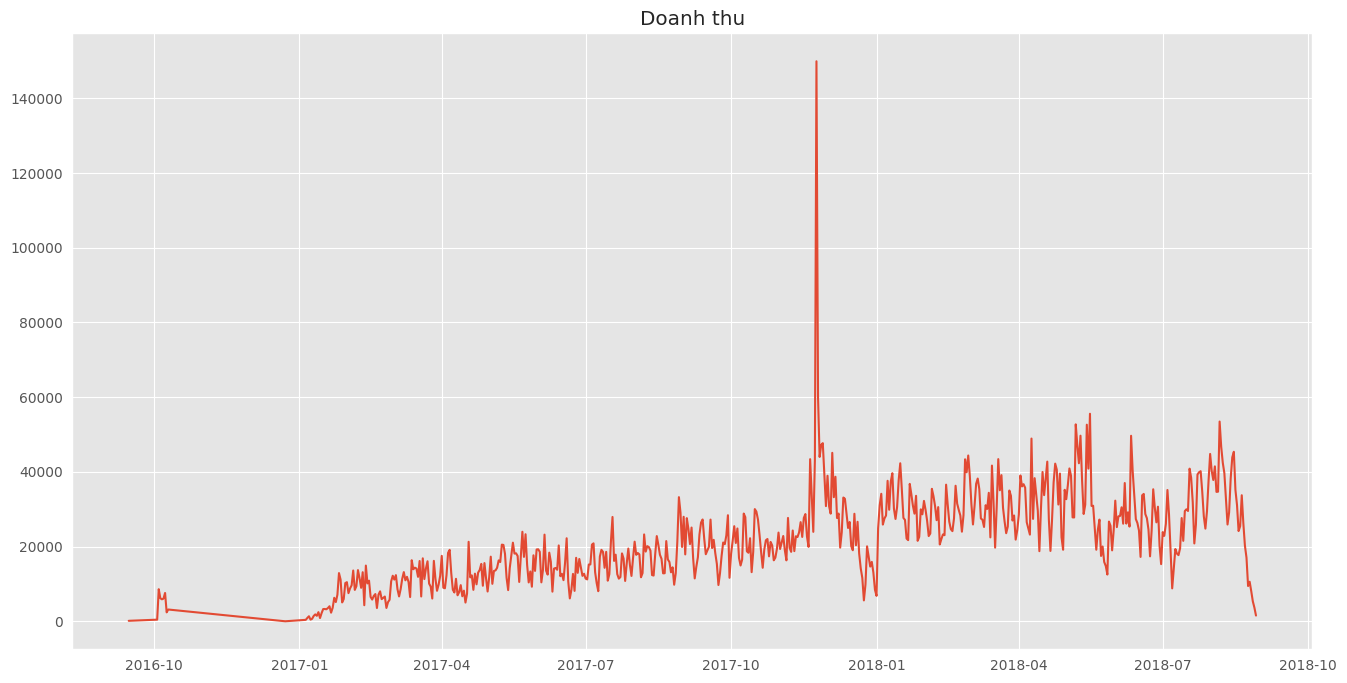

In [4]:
#Vẽ biểu đồ dạng đường như trong time series
plt.figure(figsize=(16,8))
plt.plot(df['Revenue'],label='Doanh thu')
plt.title('Doanh thu')

### Vẽ biểu đồ boxplot để xem phân bố của dữ liệu

([], [])

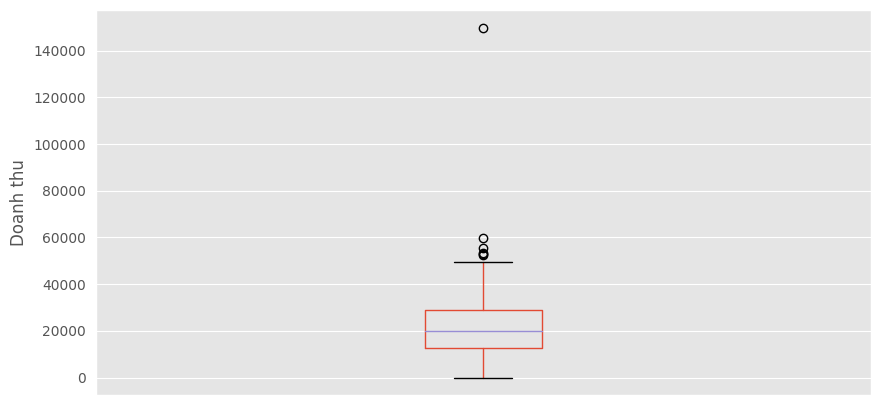

In [5]:
#Vẽ biểu đồ boxplot để xem phân bố của dữ liệu
df.boxplot(figsize=(10,5))
#đổi tên trục x
plt.ylabel("Doanh thu")
#xóa chữ revenue
plt.xticks(ticks=[])

### Vẽ biểu đồ histogram của Revenue để xem tần xuất của dữ liệu

Text(0.5, 0, 'Doanh thu')

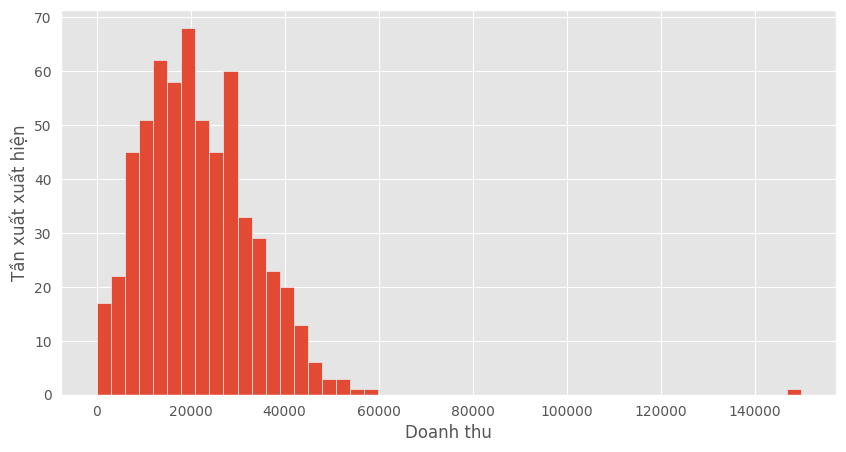

In [6]:
#Vẽ biểu đồ  histogram của Revenue
df['Revenue'].plot.hist(bins=50,figsize=(10,5))
plt.ylabel("Tần xuất xuất hiện")
plt.xlabel("Doanh thu")

## Tiền xử lý dữ liệu

### Thực hiện bỏ đi ngày 24/11/2017 vì đây là ngày black friday nên doanh thu tăng cao đột xuất, có thể làm nhiễu mô hình nên cần bỏ đi

In [7]:
date_to_remove = pd.to_datetime('2017-11-24')
df=df.drop(date_to_remove)

### Ta tiến hành bỏ các ngày sau:

- Bỏ đi dữ liệu trong năm 2016 vì dữ liệu trong năm 2016 khá thưa thớt

- Bỏ các ngày sau 20/8/2018 vì các ngày sau ngày này có nhiễu khá lớn, giảm đột xuất

In [8]:
begin_date=pd.to_datetime('2017-01-01')
end_date=pd.to_datetime('2018-08-01')
df=df[begin_date:end_date]

### Ta tiến hành vẽ biểu đồ trong 1 tháng (25/02/2017 - 25/03/2017) để xem thử xem dữ liệu có tính chu kỳ hay không?

<function matplotlib.pyplot.show(close=None, block=None)>

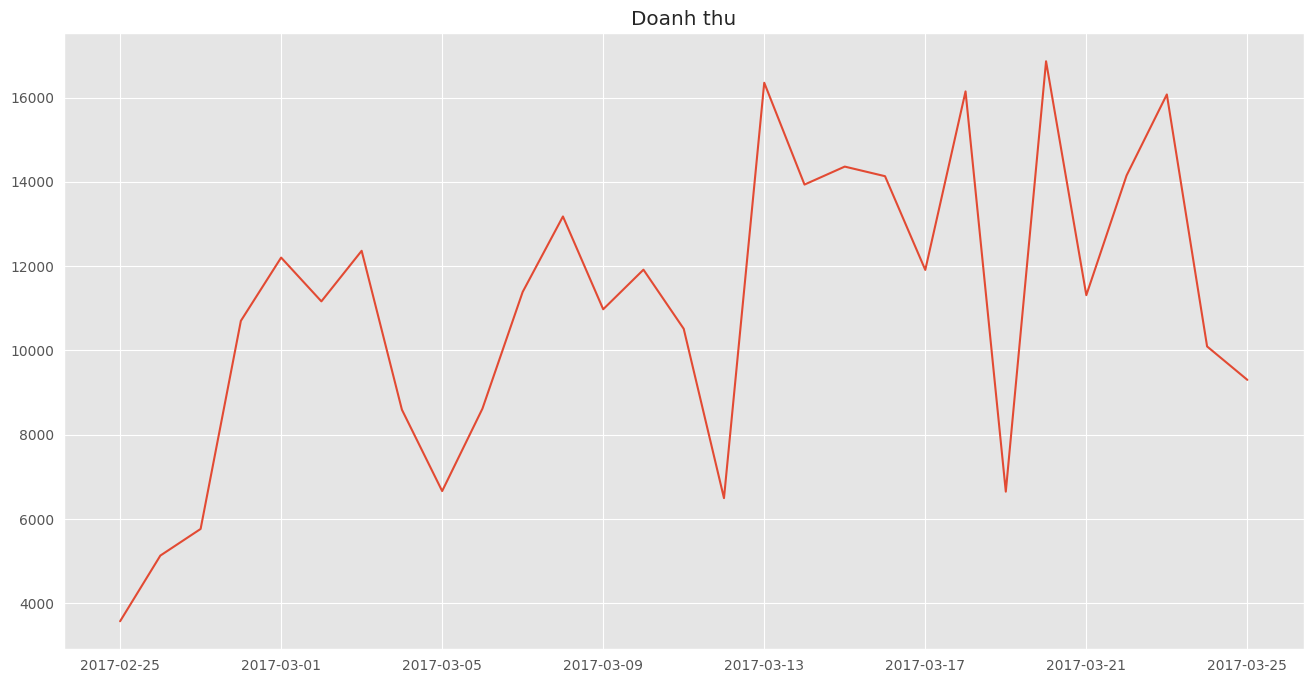

In [9]:
plt.figure(figsize=(16,8))
begin_date=pd.to_datetime('2017-02-25')
end_date=pd.to_datetime('2017-03-25')
plt.plot(df[begin_date:end_date],label='Doanh thu')
#thêm grid
plt.title('Doanh thu')
plt.show

### Theo biểu đồ trên, trong 1 tháng có đến 4 chu kỳ diễn ra. Vì vậy, ta có thể kết luận 1 chu kỳ của dữ liệu là 7 ngày

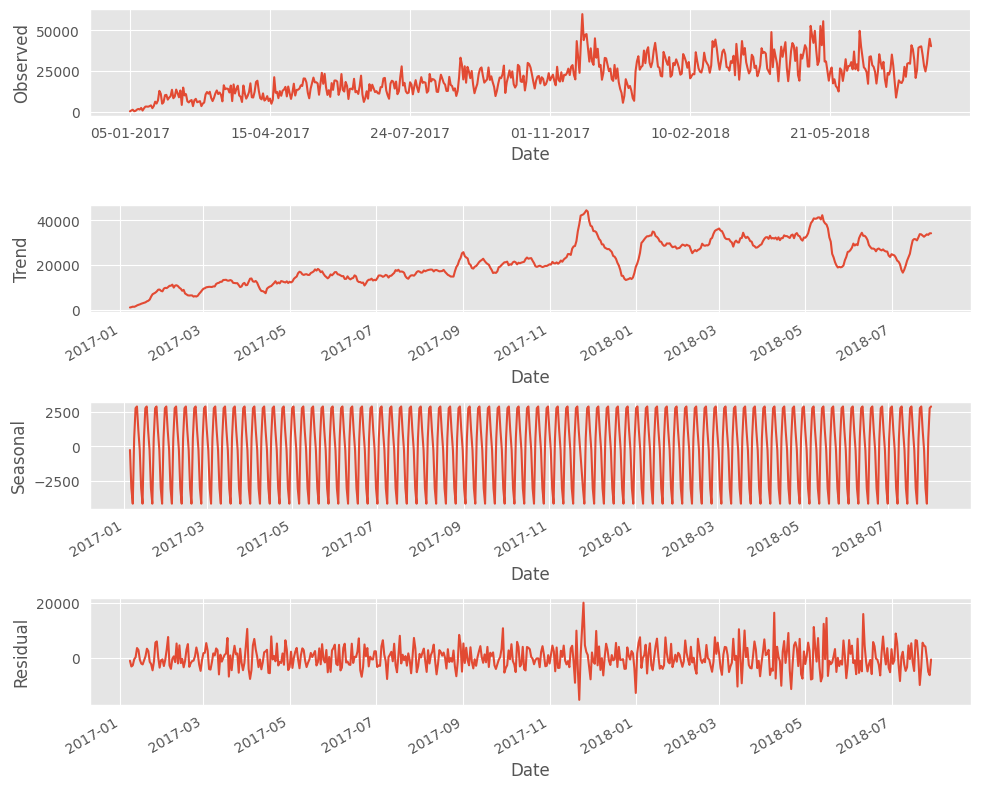

In [10]:
result = seasonal_decompose(df['Revenue'], model='additive', period=7)
#chuyển giá trị trên trục x nghiêng 45 độ
result.observed.index = result.observed.index.strftime('%d-%m-%Y')
#Tạo 4 subplots
fig, ax = plt.subplots(4, 1, figsize=(10, 8))
#Thực hiện gắn dữ liệu vào từng subplot
result.observed.plot(ax=ax[0])
ax[0].set_ylabel('Observed')
result.trend.plot(ax=ax[1])
ax[1].set_ylabel('Trend')
result.seasonal.plot(ax=ax[2])
ax[2].set_ylabel('Seasonal')
result.resid.plot(ax=ax[3])
ax[3].set_ylabel('Residual')
plt.tight_layout()
plt.show()

## SARIMA

### Chia dữ liệu theo tỉ lệ 7:3

In [11]:
train_size = int(0.7 * len(df))
test_size = len(df) - train_size

In [12]:
train = df[:train_size]
test = df[train_size:]

### Train model bằng AutoArima

Cho chạy AutoArima để tìm kiếm các siêu tham số (p, d, q, P, D, Q p) phù hợp với mô hình. Tham số m=7 là chu kỳ của dữ liệu đã tìm được ở phía trên.

In [13]:
model=auto_arima(train,trace=True,seasonal=True, m=7, error_action='ignore'
                 ,start_p=0, start_q=0
                 ,max_q=5, max_p=5
                 ,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=7980.569, Time=2.41 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=8036.657, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=7979.778, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=7953.867, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=8034.691, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=7975.609, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=7896.645, Time=3.08 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=7943.233, Time=0.50 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=7908.628, Time=4.10 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=7908.839, Time=4.29 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=7937.690, Time=1.30 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=7920.512, Time=2.00 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=6.50 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=7901.565, Time=3.81 sec
 ARIMA(0,1,2)(1,0,1)[7] intercept   : 

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  401
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -3939.564
Date:                           Mon, 12 Jun 2023   AIC                           7889.128
Time:                                   15:08:53   BIC                           7909.086
Sample:                                        0   HQIC                          7897.032
                                           - 401                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2059      0.061      3.373      0.001       0.086       0.326
ma.L1         -0.7098      0.048    -14.877      0.000      -0.803      -0.616
ar.S.L7        0.9783      0.017     55.903      0.000       0.944       1.013
ma.S.L7       -0.8837      0.038    -23.165      0.000      -0.958      -0.809
sigma2      2.075e+07   3.23e-10   6.42e+16      0.000    2.08e+07    2.08e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               149.34
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               3.24   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+32. Standard errors may be unstable.
"""

In [15]:
#Quá trình testing
y_test=np.array(test)
y_pred=model.predict(n_periods=len(y_test))
y_pred.index=test.index

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Vẽ biểu đồ dự báo

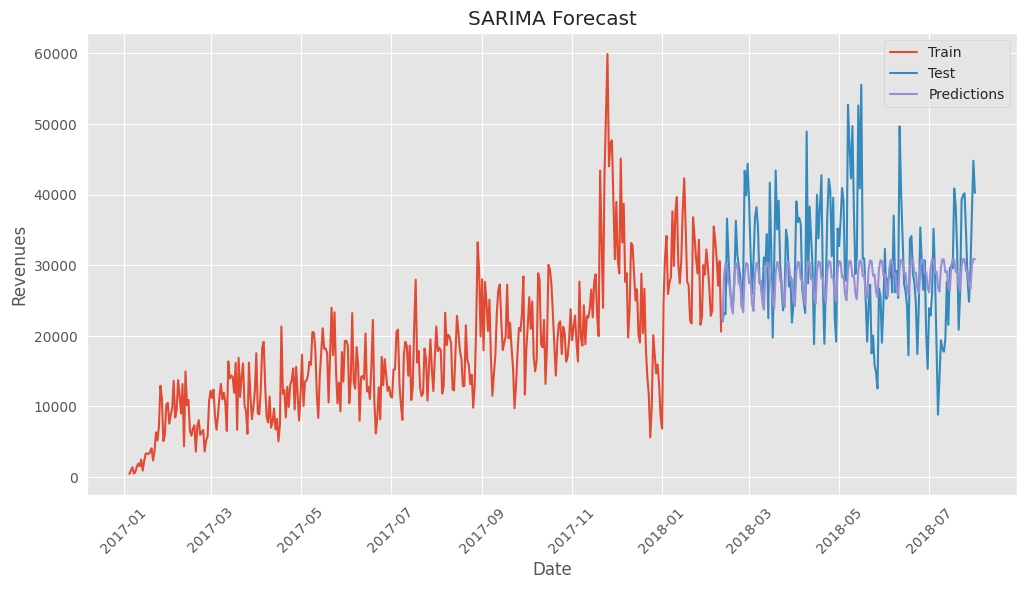

In [16]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train)
plt.plot(test)
plt.plot(y_pred)
plt.xticks(rotation=45)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Revenues')
plt.legend(['Train', 'Test', 'Predictions'])

### Test và Predict

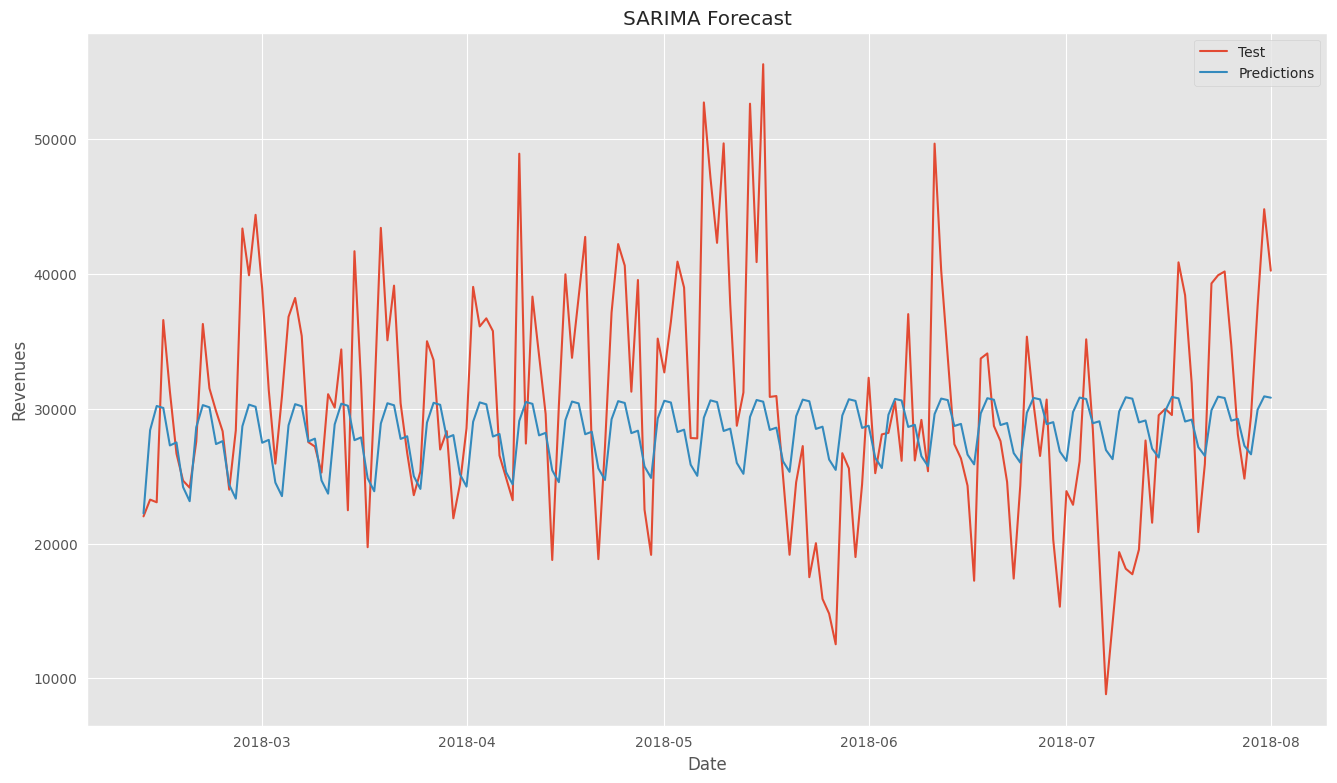

In [17]:
plt.figure(figsize=(16,9))
plt.plot(test)
plt.plot(y_pred)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Revenues')
plt.legend( ['Test', 'Predictions'])

### Các chỉ số đánh giá mô hình

In [18]:
rmse=np.sqrt(mean_squared_error(test,y_pred))
print("RMSE: ",rmse)
mape=mean_absolute_percentage_error(test,y_pred)*100
print("MAPE: ",mape)

RMSE:  8029.996881144362
MAPE:  21.835729543034187


### Dự báo với khoảng thời gian ngoài dữ liệu

Hàm nhận vào 1 ngày và thực hiện dự báo tới ngày đó

In [19]:
def predict_to(end):
    start=test[-1:].index.date[0]
    start=pd.to_datetime(start)+timedelta(days=1)
    end=pd.to_datetime(end)
    #Tính khoảng thời gian giữa 2 ngày
    delta=end-start
    #dự báo 
    period=test_size+delta.days
    y_pred=model.predict(n_periods=period)
    arr=pd.date_range(start,periods=delta.days,freq='D')
    index=test.index.append(arr)
    y_pred.index=index
    return y_pred

Hàm nhận vào số ngày dự đoán và trả về dự đoán từ ngày đầu của test tới tập đó

In [20]:
def predict_periods(periods):
    #lấy ra ngày cuối cùng trong tập test
    start_period=test[-1:].index.date[0]
    period=test_size+periods
    y_pred=model.predict(n_periods=period)
    arr=pd.date_range(start_period,periods=periods,freq='D')
    index=test.index.append(arr)
    y_pred.index=index
    return y_pred

### Chọn ngày cần dự báo

In [21]:
next30days=predict_to('2018-09-20')

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [22]:
next30days=predict_periods(30)

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


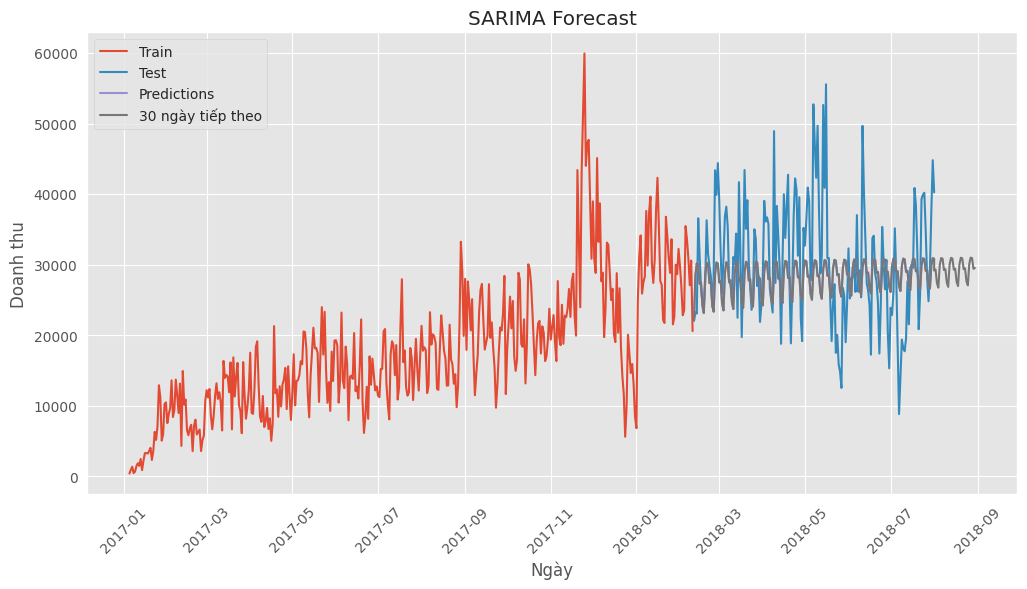

In [23]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train)
plt.plot(test)
plt.plot(y_pred)
plt.plot(next30days)
plt.xticks(rotation=45)
plt.title('SARIMA Forecast')
plt.xlabel('Ngày')
plt.ylabel('Doanh thu')
plt.legend(['Train', 'Test', 'Predictions','30 ngày tiếp theo'])

## Random Forest

### Chuẩn bị dữ liệu

In [24]:
#chuẩn hóa dữ liệu
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [25]:
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

![Picture title](image-20230613-171503.png)

In [26]:
# Window sliding
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

### Huấn luyện mô hình

In [27]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train.reshape(X_train.shape[0],time_step), y_train.reshape(y_train.shape[0],))

RandomForestRegressor(random_state=0)

In [28]:
test_predict=regressor.predict(X_test.reshape(X_test.shape[0],time_step))
test_predict = test_predict.reshape(-1,1)
print("Test data prediction:", test_predict.shape)
test_predict_inverse =scaler.inverse_transform(test_predict.reshape(-1,1))

Test data prediction: (141, 1)


In [29]:
def create_date_array():
    date_array = []

    for i in range(30, 0, -1):  # Tạo mảng trong 30 ngày
        date_array.append("Ngày t-"+str(i))

    return date_array

In [30]:
regressor.feature_importances_

array([0.00778918, 0.00778596, 0.01551352, 0.01121074, 0.01113457,
       0.00864318, 0.00749347, 0.00588655, 0.00571554, 0.00864361,
       0.00793153, 0.00752329, 0.00781989, 0.00986544, 0.01041345,
       0.01288079, 0.05681411, 0.00910019, 0.00638067, 0.00621695,
       0.0078865 , 0.00727995, 0.00887758, 0.05968611, 0.03512731,
       0.03003327, 0.01230218, 0.04323155, 0.02795695, 0.54285595])

In [31]:
print(create_date_array())

['Ngày t-30', 'Ngày t-29', 'Ngày t-28', 'Ngày t-27', 'Ngày t-26', 'Ngày t-25', 'Ngày t-24', 'Ngày t-23', 'Ngày t-22', 'Ngày t-21', 'Ngày t-20', 'Ngày t-19', 'Ngày t-18', 'Ngày t-17', 'Ngày t-16', 'Ngày t-15', 'Ngày t-14', 'Ngày t-13', 'Ngày t-12', 'Ngày t-11', 'Ngày t-10', 'Ngày t-9', 'Ngày t-8', 'Ngày t-7', 'Ngày t-6', 'Ngày t-5', 'Ngày t-4', 'Ngày t-3', 'Ngày t-2', 'Ngày t-1']


<BarContainer object of 30 artists>

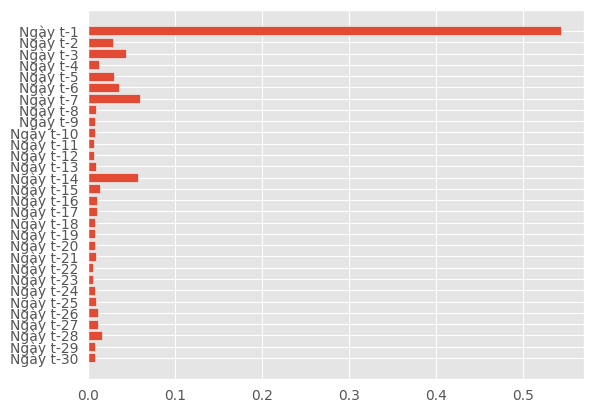

In [32]:
plt.barh(create_date_array(), regressor.feature_importances_)

### Đánh giá mô hình

In [33]:
rmse=np.sqrt(mean_squared_error(test[(time_step+1):],test_predict_inverse))
print("RMSE: ",rmse)
mape=mean_absolute_percentage_error(test[(time_step+1):],test_predict_inverse)*100
print("MAPE: ",mape)

RMSE:  8315.48755002636
MAPE:  23.741716228628587


In [34]:
pred_df_rf = pd.DataFrame(test_predict_inverse, index = test[(time_step+1):].index)

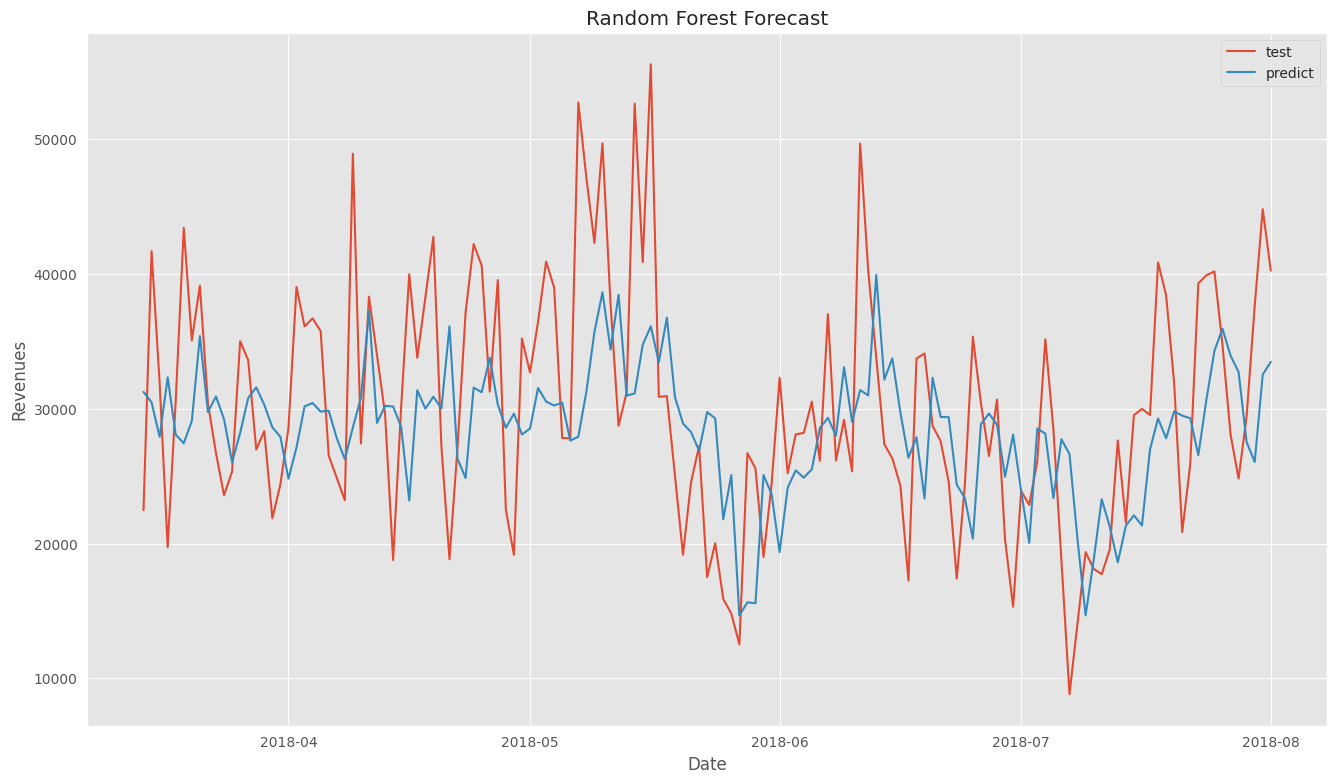

In [35]:
plt.figure(figsize=(16,9))
plt.plot(test[(time_step+1):], label = 'test')
plt.plot(pred_df_rf, label='predict')
plt.title('Random Forest Forecast')
plt.xlabel('Date')
plt.ylabel('Revenues')
plt.legend()
plt.show()

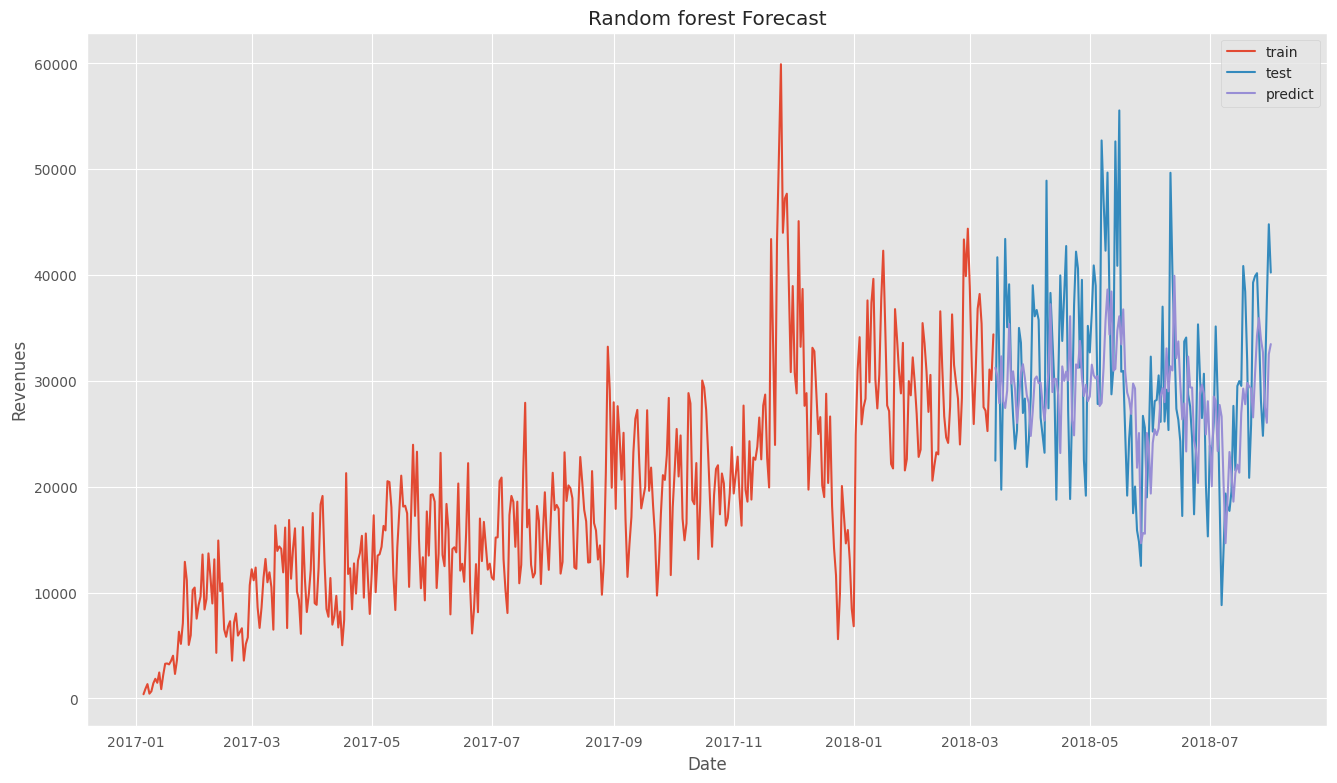

In [36]:
plt.figure(figsize=(16,9))
plt.plot(pd.concat([train, test[:time_step+1]]), label='train')
plt.plot(test[(time_step+1):], label = 'test')
plt.plot(pred_df_rf, label='predict')
plt.title('Random forest Forecast')
plt.xlabel('Date')
plt.ylabel('Revenues')
plt.legend()
plt.show()

In [37]:
df1[-time_step:].reshape(1,-1).reshape(1,30)

array([[0.43179783, 0.58377171, 0.47190946, 0.30811765, 0.14143511,
        0.22958895, 0.31855429, 0.29783656, 0.29097483, 0.32176318,
        0.45769516, 0.35520659, 0.48918045, 0.49710045, 0.48940773,
        0.67970613, 0.63881844, 0.52915233, 0.34349449, 0.42845339,
        0.65342496, 0.66361551, 0.66832327, 0.57695618, 0.46543273,
        0.41014211, 0.48808876, 0.6250471 , 0.74594186, 0.66934726]])

In [38]:


np.append(df1[-time_step:].reshape(1,-1).reshape(1,30)[0], 10)

array([ 0.43179783,  0.58377171,  0.47190946,  0.30811765,  0.14143511,
        0.22958895,  0.31855429,  0.29783656,  0.29097483,  0.32176318,
        0.45769516,  0.35520659,  0.48918045,  0.49710045,  0.48940773,
        0.67970613,  0.63881844,  0.52915233,  0.34349449,  0.42845339,
        0.65342496,  0.66361551,  0.66832327,  0.57695618,  0.46543273,
        0.41014211,  0.48808876,  0.6250471 ,  0.74594186,  0.66934726,
       10.        ])

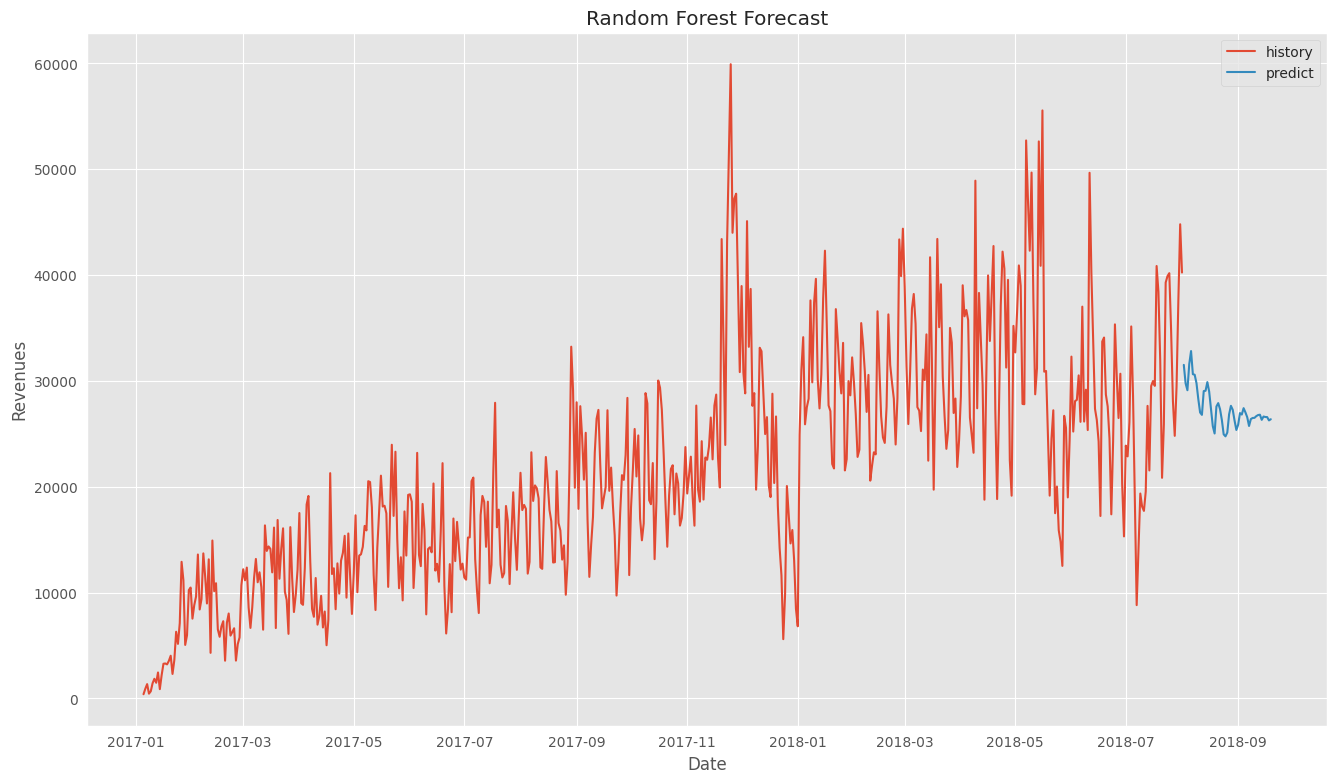

In [39]:
def predict_to_rf(end):
    start=test[-1:].index.date[0]
    start=pd.to_datetime(start)+timedelta(days=1)
    end=pd.to_datetime(end)
    #Tính khoảng thời gian giữa 2 ngày
    delta=end-start
    #dự báo 
    period=test_size+delta.days

    arr=pd.date_range(start,periods=delta.days,freq='D')

    X_test_next = df1[-time_step:].reshape(1,-1).reshape(1,30)
    pred_next = np.array([])

    for i in range(delta.days):
        y_pred_next = regressor.predict(X_test_next.reshape(1,-1).reshape(1,30))
        X_test_next = np.append(X_test_next,y_pred_next[0])[1:]
        
        pred_next = np.append(pred_next,y_pred_next[0])
    
    pred_next_rf = pd.DataFrame(scaler.inverse_transform(pred_next.reshape(-1,1)), index = arr)

    plt.figure(figsize=(16,9))
    plt.plot(df, label = 'history')
    plt.plot(pred_next_rf, label='predict')
    plt.title('Random Forest Forecast')
    plt.xlabel('Date')
    plt.ylabel('Revenues')
    plt.legend()
    plt.show()

    return pred_next_rf

next30days = predict_to_rf('2018-09-20')

## CNN-LSTM

### Huấn luyện mô hình

In [40]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow.keras.backend as K

model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 14, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss=root_mean_squared_error)

history = model.fit(X_train.reshape(X_train.shape[0],1,time_step,1), np.array(y_train), validation_data=(X_test.reshape(X_test.shape[0],1,time_step,1), np.array(y_test)), epochs=100,batch_size=40, verbose=1, shuffle = False)

2023-06-12 15:08:57.599097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 15:08:57.719250: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-12 15:08:57.723515: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-12 15:08:57.723531: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [41]:
# After the model has been constructed, we'll summarise it
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 28, 64)        256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 14, 64)        0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 12, 128)       24704     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 1, 6, 128)        0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 4, 64)         2

### Đánh giá mô hình

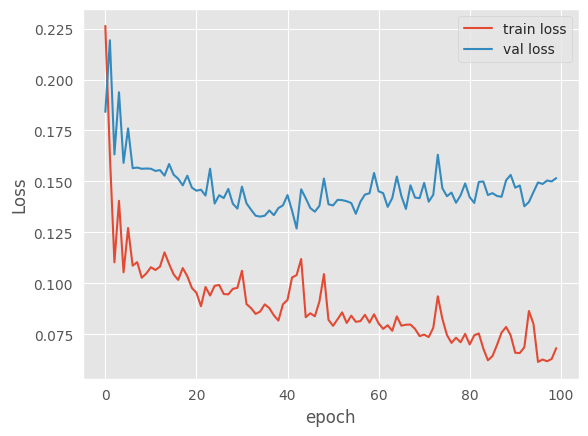

In [42]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [43]:
predicted  = model.predict(X_test.reshape(X_test.shape[0],1,time_step,1))

5/5 [==============================] - 1s 3ms/step


In [44]:
rmse=np.sqrt(mean_squared_error(test[(time_step+1):],scaler.inverse_transform(predicted.reshape(-1,1))))
print("RMSE: ",rmse)
mape=mean_absolute_percentage_error(test[(time_step+1):],scaler.inverse_transform(predicted.reshape(-1,1)))*100
print("MAPE: ",mape)

RMSE:  10174.345656222247
MAPE:  31.126243695742982


In [45]:
pred_df = pd.DataFrame(scaler.inverse_transform(predicted.reshape(-1,1)), index = test[(time_step+1):].index)

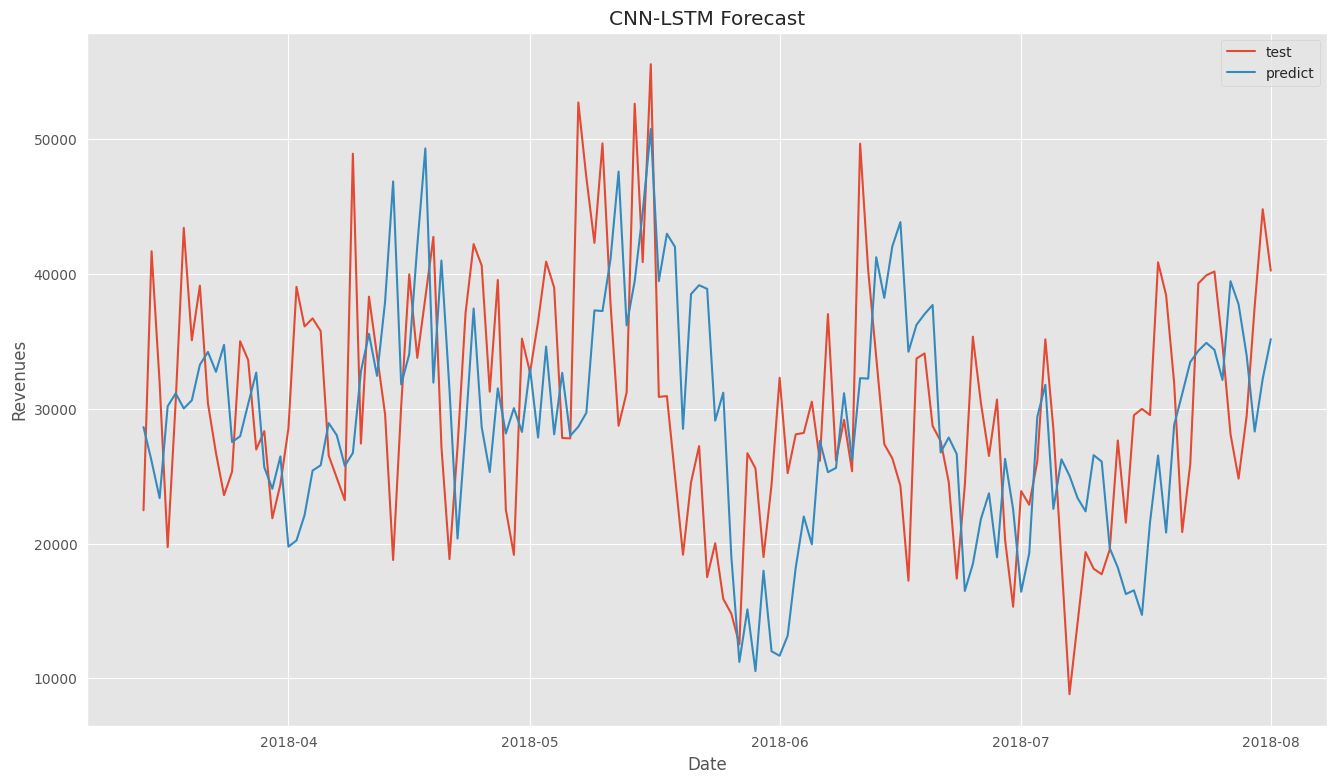

In [46]:
plt.figure(figsize=(16,9))
plt.plot(test[(time_step+1):], label = 'test')
plt.plot(pred_df, label='predict')
plt.title('CNN-LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Revenues')
plt.legend()
plt.show()

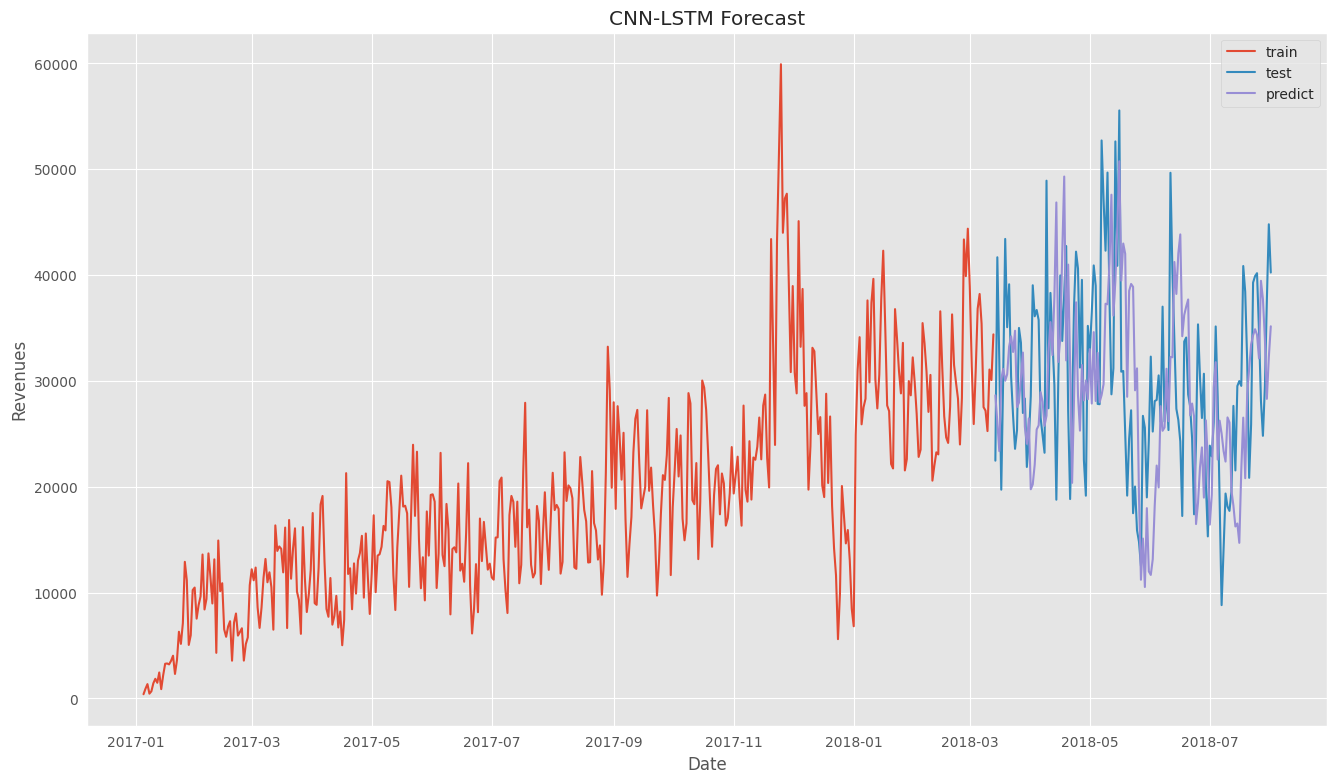

In [47]:
plt.figure(figsize=(16,9))
plt.plot(pd.concat([train, test[:time_step+1]]), label='train')
plt.plot(test[(time_step+1):], label = 'test')
plt.plot(pred_df, label='predict')
plt.title('CNN-LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Revenues')
plt.legend()
plt.show()

### Nhập hoặc chọn ngày dự báo

1/1 [==============================] - 0s 47ms/step


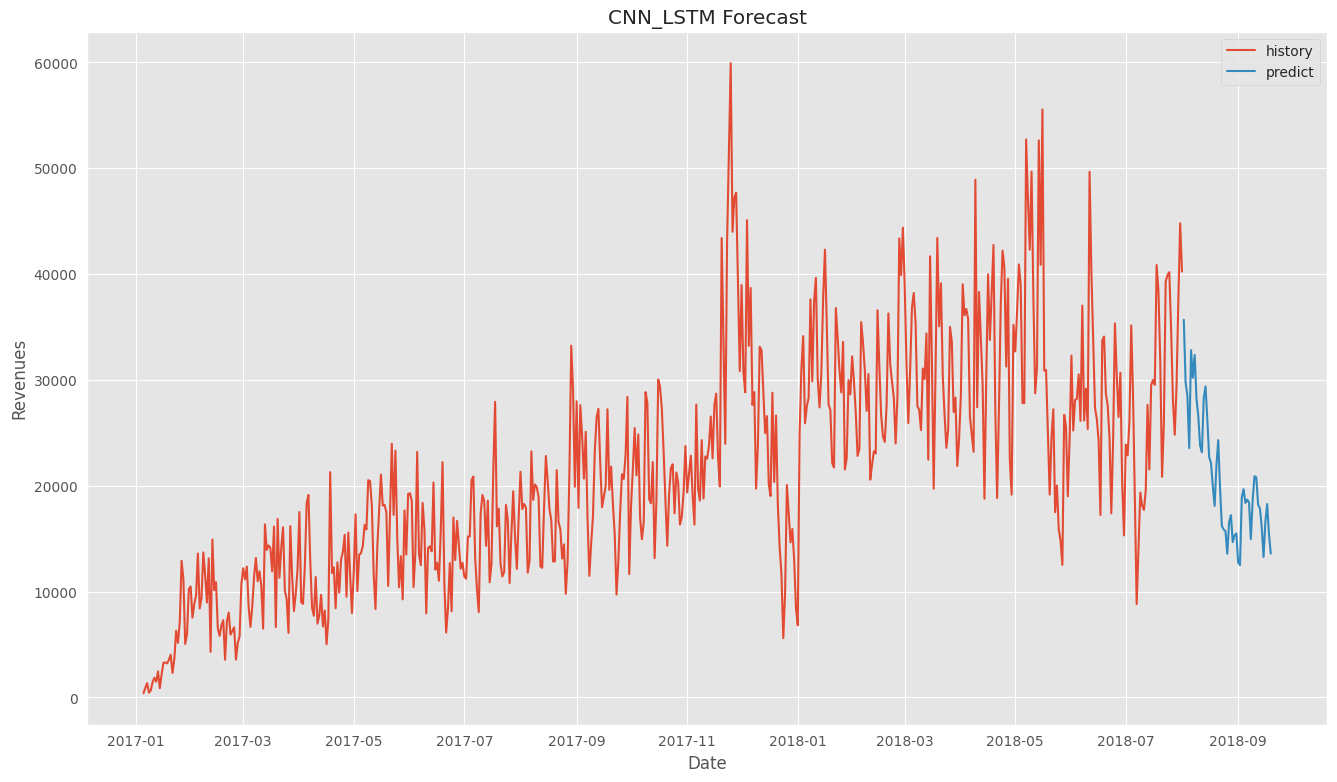

In [48]:
def predict_to_cnn_lstm(end):
    start=test[-1:].index.date[0]
    start=pd.to_datetime(start)+timedelta(days=1)
    end=pd.to_datetime(end)
    #Tính khoảng thời gian giữa 2 ngày
    delta=end-start
    #dự báo 
    period=test_size+delta.days

    arr=pd.date_range(start,periods=delta.days,freq='D')

    X_test_next = df1[-time_step:].reshape(1,-1).reshape(1,30)
    pred_next = np.array([])

    for i in range(delta.days):
        y_pred_next = model.predict(X_test_next.reshape(1,-1).reshape(1,1,time_step,1))
        X_test_next = np.append(X_test_next,y_pred_next[0])[1:]
        
        pred_next = np.append(pred_next,y_pred_next[0])
    
    pred_next_rf = pd.DataFrame(scaler.inverse_transform(pred_next.reshape(-1,1)), index = arr)

    plt.figure(figsize=(16,9))
    plt.plot(df, label = 'history')
    plt.plot(pred_next_rf, label='predict')
    plt.title('CNN_LSTM Forecast')
    plt.xlabel('Date')
    plt.ylabel('Revenues')
    plt.legend()
    plt.show()

    return pred_next_rf

next30days = predict_to_cnn_lstm('2018-09-20')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b3c11716-5688-4fcd-9514-e643305cf762' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>